In [1]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

# Helper libraries
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


In [2]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


train_images=np.expand_dims(train_images,axis=3)
train_images = train_images / 255.0

test_images=np.expand_dims(test_images,axis=3)
test_images = test_images / 255.0

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Base CNN

In [3]:
IMAGE_SHAPE = [28, 28, 1]

inputs = tf.keras.Input(shape=(*IMAGE_SHAPE,))
x = tf.keras.layers.Conv2D(32, kernel_size=5, padding='SAME', activation=tf.nn.relu)(inputs)
x = tf.keras.layers.MaxPooling2D(
    pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x = tf.keras.layers.Conv2D(64, kernel_size=5, padding='SAME', activation=tf.nn.relu)(x)
x = tf.keras.layers.MaxPooling2D(
    pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x = tf.keras.layers.Conv2D(128, kernel_size=5, padding='SAME', activation=tf.nn.relu)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.layers.Dense(
    84, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.4)(x)
predictions = tf.layers.Dense(10,activation=tf.nn.softmax)(x)

cnn = tf.keras.Model(inputs=inputs, outputs=predictions)


checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

cnn.compile(optimizer='adam', 
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
train_cnn=False
if train_cnn:

    cnn.fit(train_images, train_labels, epochs=200,
          callbacks = [cp_callback])
else:
    cnn.load_weights(checkpoint_path)

In [9]:
test_loss, test_acc = cnn.evaluate(test_images, test_labels)



print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 55us/sample - loss: 0.2063 - acc: 0.9872
Test accuracy: 0.9872


In [10]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
__________

In [11]:


class distiller(tf.keras.Model):
    
    def __init__(self, ext_model,lay_num, hidden_size=100):

        super(distiller, self).__init__()
        self.IMAGE_SHAPE  = [28, 28, 1]

        self.FILTER_SHAPE = ext_model.layers[lay_num].output.shape.as_list()[1:]

        self.ext_model_layers=ext_model.layers[:lay_num]
        for lay in self.ext_model_layers:
            lay.trainable = False
        
        self.ext_post_net=ext_model.layers[lay_num:]
        for lay in self.ext_post_net:
            lay.trainable = False
        
        #for layer in intermediate_layer_model.layers:
        #    layer.trainable = False


        self.rs = tf.keras.layers.Reshape([-1,np.prod(self.IMAGE_SHAPE)])
        self.hidden = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(np.prod(self.FILTER_SHAPE), activation=tf.nn.relu)
        #self.dropout = tf.keras.layers.Dropout(0.5)
    


    def call(self, inputs, training=False):

        y=self.out(self.hidden(self.rs(inputs)))

        if training:
            y_ext = inputs
            for lay in self.ext_model_layers:
                y_ext = lay(y_ext)
            y_ext.reshape([-1,y_ext.output.shape.as_list()])
            return tf.math.subtract(tf.math.l2_normalize(y_ext),tf.math.l2_normalize(y))

        return y
    
    def mix_pred(self,inputs):
        
        y=self.out(self.hidden(self.rs(inputs)))
        y.reshape([-1,self.FILTER_SHAPE])
        for lay in self.ext_post_net:
                y = lay(y)
        return y



def loss(y_true,y_pred):
    return tf.mean_square_error(un[0], tf.zeros_like(y_true))

In [12]:
def training_generator(hidden_units,n_test, folder, n_epochs=100):
    #cnn.layers[1].output
    model = distiller(cnn, 5, hidden_size=hidden_units)
    opt=tf.train.AdamOptimizer()#learning_rate=0.01)# Cambiar a lr si se usa tf.keras
    model.compile(loss=tf.losses.absolute_difference,
                  metrics=[tf.losses.absolute_difference],
                 optimizer=opt)

    checkpoint_path = folder+"training_distiller"+str(hidden_units)+"-"+str(n_test)+"/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                     save_weights_only=True,
                                                     verbose=0)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=checkpoint_dir.replace("cp.ckpt","logs"))
    

    shape_out=np.prod(cnn.layers[5].output.shape.as_list()[1:])
    model.fit(train_images, 
              np.zeros([train_images.shape[0],shape_out]), 
              epochs=n_epochs,
              callbacks = [cp_callback, tensorboard_callback],#,es_callback],
              verbose=0,)

    np.save(folder+"c5u"+str(hidden_units)+"-"+str(n_test),model.history.history['loss'])

# Visualization

attemp 0 with 500 units
attemp 1 with 500 units
attemp 2 with 500 units
attemp 3 with 500 units
attemp 4 with 500 units
attemp 5 with 500 units


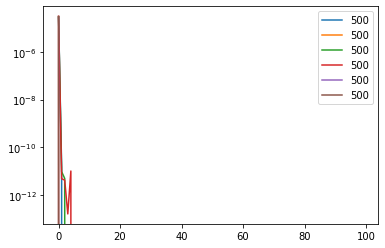

In [14]:
train_distillators=True
if train_distillators:
    #units = [10, 100, 500, 780, 790, 1000, 5000, 10000]
    #units = [50,150,200,250,300,350,400,450]
    units = [500]#[10,50,150,500,1000]
    n_exp = 6
    plt.figure()
    folder="exp-7n/"
    msg ="attemp %n with %j units"

    n_epochs = 100
    for hidden_units in units:
        for i in range(n_exp):
            print(msg.replace("%n",str(i)).replace("%j",str(hidden_units)))
            training_generator(hidden_units, i, folder, n_epochs=n_epochs)
            plt.semilogy(
                np.load(folder + "c5u" + str(hidden_units) + "-" + str(i) + ".npy"),
                label=str(hidden_units),
            )
            plt.legend()
            plt.savefig(folder + "loss_plot.png")

# repiping

In [10]:
def get_distiller(n_units,folder="exp-7/"):
    checkpoint_path = folder+"training_distiller"+str(n_units)+"/cp.ckpt"
    model = distiller(cnn, 5, hidden_size=n_units)
    opt=tf.train.AdamOptimizer()#learning_rate=0.01)# Cambiar a lr si se usa tf.keras
    model.compile(loss='mean_squared_error',
                  metrics=['mean_squared_error'],
                 optimizer=opt)
    model.load_weights(checkpoint_path)
    return model

In [11]:
class repiped_distiller(tf.keras.Model):
    
    def __init__(self, ext_model,lay_num, hidden_size=100, trainable=False):

        super(repiped_distiller, self).__init__()
        self.IMAGE_SHAPE  = [28, 28, 1]

        self.FILTER_SHAPE = ext_model.layers[lay_num].output.shape.as_list()[1:]
        
        if self.trainable:
            self.ext_model_layers=ext_model.layers[:lay_num]
            for lay in self.ext_model_layers:
                lay.trainable = False
        
        self.ext_post_net=ext_model.layers[lay_num+1:]
        for lay in self.ext_post_net:
            lay.trainable = False
        
        #for layer in intermediate_layer_model.layers:
        #    layer.trainable = False


        self.rs = tf.keras.layers.Reshape([-1,np.prod(self.IMAGE_SHAPE)],name="distilator_input")
        self.hidden = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu,name="distilator_hidden")
        self.out = tf.keras.layers.Dense(np.prod(self.FILTER_SHAPE), activation=tf.nn.relu,name="distilator_output")
        #self.dropout = tf.keras.layers.Dropout(0.5)
    


    def call(self, inputs, training=False):

        y=self.out(self.hidden(self.rs(inputs)))
        if self.trainable:
            if training:
                y_ext = inputs
                for lay in self.ext_model_layers:
                    y_ext = lay(y_ext)
                y_ext.reshape([-1,y_ext.output.shape.as_list()])
                return tf.math.subtract(t,y_ext)

        self.rs = tf.keras.layers.Reshape([-1,*self.FILTER_SHAPE[1:]  ])
        for lay in self.ext_post_net:
                y = lay(y)
        return y
    

        



def loss(y_true,y_pred):
    return tf.mean_square_error(un[0], tf.zeros_like(y_true))

In [29]:
n_unnits=1000
trial=0
folder="exp-7/"

r_model=repiped_distiller(cnn,5, hidden_size=n_unnits)

r_model.compile(optimizer='adam', 
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

checkpoint_path = folder+"training_distiller%i-%i/cp.ckpt"%(n_unnits, trial)
r_model.load_weights(checkpoint_path)

In [30]:
test_loss, test_acc = r_model.evaluate(train_images, train_labels)


print('Test accuracy:', test_acc)

60000/60000 [==============================] - 4s 71us/sample - loss: 2.3627 - acc: 0.1124
Test accuracy: 0.11236667


In [31]:
model.fit(data, labels, epochs=10, batch_size=32)

NameError: name 'model' is not defined

In [32]:
r_model.predict(train_images[:400])

array([[0.06837451, 0.18799709, 0.05697727, ..., 0.09307691, 0.12250913,
        0.14729042],
       [0.06837451, 0.18799709, 0.05697727, ..., 0.09307691, 0.12250913,
        0.14729042],
       [0.06837451, 0.18799709, 0.05697727, ..., 0.09307691, 0.12250913,
        0.14729042],
       ...,
       [0.06837451, 0.18799709, 0.05697727, ..., 0.09307691, 0.12250913,
        0.14729042],
       [0.06837451, 0.18799709, 0.05697727, ..., 0.09307691, 0.12250913,
        0.14729042],
       [0.06837451, 0.18799709, 0.05697727, ..., 0.09307691, 0.12250913,
        0.14729042]], dtype=float32)

In [18]:
weights=r_model.get_weights()

Text(0.5, 1.0, 'Pesos intento 1')

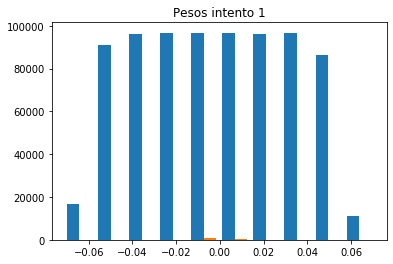

In [19]:
plt.hist(r_model.layers[10].get_weights())
plt.title("Pesos intento 1")

In [ ]:
r_model.summary()